# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from catboost import CatBoostClassifier
import shap
import warnings
warnings.filterwarnings('ignore')

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 데이터 읽어오기


In [2]:
ROOT_DIR = "data"
random_seed = 110

# Load data
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))
test_data = test_data[train_data.columns]
train_data.head()

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


In [3]:
# mixed_columns = [
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam",
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam",
#     "Stage1 Circle1 Distance Speed Collect Result_Dam",
#     "THICKNESS 1 Collect Result_Dam",
#     "WorkMode Collect Result_Dam",
#     "GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave",
#     "GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave",
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1",
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1",
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2",
#     "HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2"
# ]

# train_data = train_data.drop(mixed_columns, axis=1)
# test_data = test_data.drop(mixed_columns, axis=1)

In [4]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

def perform_minibatch_kmeans_clustering(data, n_clusters=3, batch_size=100):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=42)
    return kmeans.fit_predict(data)

def apply_minibatch_kmeans_clustering_to_data(train_data, test_data, feature_columns, n_clusters=3, batch_size=100):
    scaler = StandardScaler()

    # 훈련 데이터에 대해 클러스터링
    train_data_scaled = scaler.fit_transform(train_data[feature_columns].dropna())
    train_labels = perform_minibatch_kmeans_clustering(train_data_scaled, n_clusters, batch_size)
    train_labels = train_labels.astype(str)
    
    # 테스트 데이터에 대해 동일한 스케일링 적용 후 클러스터링
    test_data_scaled = scaler.transform(test_data[feature_columns].dropna())
    test_labels = perform_minibatch_kmeans_clustering(test_data_scaled, n_clusters, batch_size)
    test_labels = test_labels.astype(str)
    
    return train_labels, test_labels

# 각 그룹별 클러스터 수 정의
clusters_dict = {
    'CURE END POSITION Collect Result_Dam': 2,
    'CURE STANDBY POSITION Collect Result_Dam': 1,
    'CURE START POSITION Collect Result_Dam': 2,
    'HEAD Standby Position Collect Result_Dam': 3,
    'Head Clean Position Collect Result_Dam': 4,
    'Head Purge Position Collect Result_Dam': 6,
    'Head Zero Position Collect Result_Dam': 4,
    'HEAD Standby Position Collect Result_Fill1': 3,
    'Head Clean Position Collect Result_Fill1': 2,
    'Head Purge Position Collect Result_Fill1': 3,
    'CURE END POSITION Collect Result_Fill2': 4,
    'CURE STANDBY POSITION Collect Result_Fill2': 4,
    'CURE START POSITION Collect Result_Fill2': 5,
    'HEAD Standby Position Collect Result_Fill2': 2,
    'Head Clean Position Collect Result_Fill2': 2,
    'Head Purge Position Collect Result_Fill2': 2
}


# 클러스터링 수행을 위한 그룹 정의
group_features = {
    'CURE_START_CLUSTER': ['CURE START POSITION X Collect Result_Dam', 'CURE START POSITION Z Collect Result_Dam', 'CURE START POSITION Θ Collect Result_Dam'],
    'CURE_STANDBY_CLUSTER': ['CURE STANDBY POSITION X Collect Result_Dam', 'CURE STANDBY POSITION Z Collect Result_Dam', 'CURE STANDBY POSITION Θ Collect Result_Dam'],
    'CURE_END_CLUSTER': ['CURE END POSITION X Collect Result_Dam', 'CURE END POSITION Z Collect Result_Dam', 'CURE END POSITION Θ Collect Result_Dam'],
    'HEAD_STANDBY_CLUSTER': ['HEAD Standby Position X Collect Result_Dam', 'HEAD Standby Position Y Collect Result_Dam', 'HEAD Standby Position Z Collect Result_Dam'],
    'HEAD_CLEAN_CLUSTER': ['Head Clean Position X Collect Result_Dam', 'Head Clean Position Y Collect Result_Dam', 'Head Clean Position Z Collect Result_Dam'],
    'HEAD_PURGE_CLUSTER': ['Head Purge Position X Collect Result_Dam', 'Head Purge Position Y Collect Result_Dam', 'Head Purge Position Z Collect Result_Dam'],
    'HEAD_ZERO_CLUSTER': ['Head Zero Position X Collect Result_Dam', 'Head Zero Position Y Collect Result_Dam', 'Head Zero Position Z Collect Result_Dam'],
    'STAGE2_CLUSTER': ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'],
    'STAGE3_CLUSTER': ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']
}

# 클러스터링 수행 및 결과 추가
for cluster_name, feature_columns in group_features.items():
    n_clusters = clusters_dict.get(cluster_name.replace("_CLUSTER", " Collect Result_Dam"), 3)
    train_data[cluster_name], test_data[cluster_name] = apply_minibatch_kmeans_clustering_to_data(train_data, test_data, feature_columns, n_clusters=n_clusters)



In [5]:
cure_cols = [
    'CURE_START_CLUSTER',
    'CURE_STANDBY_CLUSTER',
    'CURE_END_CLUSTER',
]
head_cols = [
    'HEAD_STANDBY_CLUSTER',
    'HEAD_CLEAN_CLUSTER',
    'HEAD_PURGE_CLUSTER',
    'HEAD_ZERO_CLUSTER',
]
stage_cols = [
    'STAGE2_CLUSTER',
    'STAGE3_CLUSTER',
]

target_cols = []
target_cols.extend(cure_cols)
target_cols.extend(head_cols)
target_cols.extend(stage_cols)

train_data['CURE_PROCESS'] = train_data['CURE_START_CLUSTER'] + '_' + train_data['CURE_STANDBY_CLUSTER'] + '_' + train_data['CURE_END_CLUSTER']
test_data['CURE_PROCESS'] = test_data['CURE_START_CLUSTER'] + '_' + test_data['CURE_STANDBY_CLUSTER'] + '_' + test_data['CURE_END_CLUSTER']

train_data['HEAD_PROCESS'] = train_data['HEAD_STANDBY_CLUSTER'] + '_' + train_data['HEAD_CLEAN_CLUSTER'] + '_' + train_data['HEAD_PURGE_CLUSTER'] + '_' + train_data['HEAD_ZERO_CLUSTER']
test_data['HEAD_PROCESS'] = test_data['HEAD_STANDBY_CLUSTER'] + '_' + test_data['HEAD_CLEAN_CLUSTER'] + '_' + test_data['HEAD_PURGE_CLUSTER'] + '_' + test_data['HEAD_ZERO_CLUSTER']

train_data['STAGE_PROCESS'] = train_data['STAGE2_CLUSTER'] + '_' + train_data['STAGE3_CLUSTER']
test_data['STAGE_PROCESS'] = test_data['STAGE2_CLUSTER'] + '_' + test_data['STAGE3_CLUSTER']

train_data = train_data.drop(target_cols, axis=1)
test_data = test_data.drop(target_cols, axis=1)

In [6]:
# 두 점 사이의 거리를 계산하는 함수
def calculate_distance(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

# 1. Head Standby -> Head Clean Distance
train_data['HEAD_Standby_to_Clean_Distance'] = calculate_distance(
    train_data['HEAD Standby Position X Collect Result_Dam'],
    train_data['HEAD Standby Position Y Collect Result_Dam'],
    train_data['HEAD Standby Position Z Collect Result_Dam'],
    train_data['Head Clean Position X Collect Result_Dam'],
    train_data['Head Clean Position Y Collect Result_Dam'],
    train_data['Head Clean Position Z Collect Result_Dam']
)

test_data['HEAD_Standby_to_Clean_Distance'] = calculate_distance(
    test_data['HEAD Standby Position X Collect Result_Dam'],
    test_data['HEAD Standby Position Y Collect Result_Dam'],
    test_data['HEAD Standby Position Z Collect Result_Dam'],
    test_data['Head Clean Position X Collect Result_Dam'],
    test_data['Head Clean Position Y Collect Result_Dam'],
    test_data['Head Clean Position Z Collect Result_Dam']
)

# 2. Head Clean -> Head Purge Distance
train_data['HEAD_Clean_to_Purge_Distance'] = calculate_distance(
    train_data['Head Clean Position X Collect Result_Dam'],
    train_data['Head Clean Position Y Collect Result_Dam'],
    train_data['Head Clean Position Z Collect Result_Dam'],
    train_data['Head Purge Position X Collect Result_Dam'],
    train_data['Head Purge Position Y Collect Result_Dam'],
    train_data['Head Purge Position Z Collect Result_Dam']
)

test_data['HEAD_Clean_to_Purge_Distance'] = calculate_distance(
    test_data['Head Clean Position X Collect Result_Dam'],
    test_data['Head Clean Position Y Collect Result_Dam'],
    test_data['Head Clean Position Z Collect Result_Dam'],
    test_data['Head Purge Position X Collect Result_Dam'],
    test_data['Head Purge Position Y Collect Result_Dam'],
    test_data['Head Purge Position Z Collect Result_Dam']
)

# 3. Head Purge -> Head Zero Distance
train_data['HEAD_Purge_to_Zero_Distance'] = calculate_distance(
    train_data['Head Purge Position X Collect Result_Dam'],
    train_data['Head Purge Position Y Collect Result_Dam'],
    train_data['Head Purge Position Z Collect Result_Dam'],
    train_data['Head Zero Position X Collect Result_Dam'],
    train_data['Head Zero Position Y Collect Result_Dam'],
    train_data['Head Zero Position Z Collect Result_Dam']
)

test_data['HEAD_Purge_to_Zero_Distance'] = calculate_distance(
    test_data['Head Purge Position X Collect Result_Dam'],
    test_data['Head Purge Position Y Collect Result_Dam'],
    test_data['Head Purge Position Z Collect Result_Dam'],
    test_data['Head Zero Position X Collect Result_Dam'],
    test_data['Head Zero Position Y Collect Result_Dam'],
    test_data['Head Zero Position Z Collect Result_Dam']
)

# 4. Head Standby -> Head Zero Distance (Direct)
train_data['HEAD_Standby_to_Zero_Distance'] = calculate_distance(
    train_data['HEAD Standby Position X Collect Result_Dam'],
    train_data['HEAD Standby Position Y Collect Result_Dam'],
    train_data['HEAD Standby Position Z Collect Result_Dam'],
    train_data['Head Zero Position X Collect Result_Dam'],
    train_data['Head Zero Position Y Collect Result_Dam'],
    train_data['Head Zero Position Z Collect Result_Dam']
)

test_data['HEAD_Standby_to_Zero_Distance'] = calculate_distance(
    test_data['HEAD Standby Position X Collect Result_Dam'],
    test_data['HEAD Standby Position Y Collect Result_Dam'],
    test_data['HEAD Standby Position Z Collect Result_Dam'],
    test_data['Head Zero Position X Collect Result_Dam'],
    test_data['Head Zero Position Y Collect Result_Dam'],
    test_data['Head Zero Position Z Collect Result_Dam']
)

# 두 점 사이의 거리를 계산하는 함수 (Theta 고려)
def calculate_distance_with_theta(x1, z1, theta1, x2, z2, theta2):
    # 각도 차이 계산 (360도를 기준으로 최소 차이 계산)
    delta_theta = np.abs(theta2 - theta1)
    delta_theta = np.minimum(delta_theta, 360 - delta_theta)
    
    # 최종 거리 계산
    return np.sqrt((x2 - x1)**2 + (z2 - z1)**2 + (delta_theta)**2)

# 1. Cure Start -> Cure Standby Distance
train_data['CURE_Start_to_Standby_Distance'] = calculate_distance_with_theta(
    train_data['CURE START POSITION X Collect Result_Dam'],
    train_data['CURE START POSITION Z Collect Result_Dam'],
    train_data['CURE START POSITION Θ Collect Result_Dam'],
    train_data['CURE STANDBY POSITION X Collect Result_Dam'],
    train_data['CURE STANDBY POSITION Z Collect Result_Dam'],
    train_data['CURE STANDBY POSITION Θ Collect Result_Dam']
)

test_data['CURE_Start_to_Standby_Distance'] = calculate_distance_with_theta(
    test_data['CURE START POSITION X Collect Result_Dam'],
    test_data['CURE START POSITION Z Collect Result_Dam'],
    test_data['CURE START POSITION Θ Collect Result_Dam'],
    test_data['CURE STANDBY POSITION X Collect Result_Dam'],
    test_data['CURE STANDBY POSITION Z Collect Result_Dam'],
    test_data['CURE STANDBY POSITION Θ Collect Result_Dam']
)

# 2. Cure Standby -> Cure End Distance
train_data['CURE_Standby_to_End_Distance'] = calculate_distance_with_theta(
    train_data['CURE STANDBY POSITION X Collect Result_Dam'],
    train_data['CURE STANDBY POSITION Z Collect Result_Dam'],
    train_data['CURE STANDBY POSITION Θ Collect Result_Dam'],
    train_data['CURE END POSITION X Collect Result_Dam'],
    train_data['CURE END POSITION Z Collect Result_Dam'],
    train_data['CURE END POSITION Θ Collect Result_Dam']
)

test_data['CURE_Standby_to_End_Distance'] = calculate_distance_with_theta(
    test_data['CURE STANDBY POSITION X Collect Result_Dam'],
    test_data['CURE STANDBY POSITION Z Collect Result_Dam'],
    test_data['CURE STANDBY POSITION Θ Collect Result_Dam'],
    test_data['CURE END POSITION X Collect Result_Dam'],
    test_data['CURE END POSITION Z Collect Result_Dam'],
    test_data['CURE END POSITION Θ Collect Result_Dam']
)

# 3. Cure Start -> Cure End Distance (Direct)
train_data['CURE_Start_to_End_Distance'] = calculate_distance_with_theta(
    train_data['CURE START POSITION X Collect Result_Dam'],
    train_data['CURE START POSITION Z Collect Result_Dam'],
    train_data['CURE START POSITION Θ Collect Result_Dam'],
    train_data['CURE END POSITION X Collect Result_Dam'],
    train_data['CURE END POSITION Z Collect Result_Dam'],
    train_data['CURE END POSITION Θ Collect Result_Dam']
)

test_data['CURE_Start_to_End_Distance'] = calculate_distance_with_theta(
    test_data['CURE START POSITION X Collect Result_Dam'],
    test_data['CURE START POSITION Z Collect Result_Dam'],
    test_data['CURE START POSITION Θ Collect Result_Dam'],
    test_data['CURE END POSITION X Collect Result_Dam'],
    test_data['CURE END POSITION Z Collect Result_Dam'],
    test_data['CURE END POSITION Θ Collect Result_Dam']
)

In [7]:
cols_to_drop = train_data.columns[train_data.nunique(dropna=False) == 1]
train_data = train_data.drop(cols_to_drop, axis=1)

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 161 entries, Equipment_Dam to CURE_Start_to_End_Distance
dtypes: float64(75), int64(62), object(24)
memory usage: 49.8+ MB


In [9]:
object_columns = train_data.select_dtypes(include=['object']).columns.tolist()
train_data[object_columns]

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,Model.Suffix_AutoClave,Workorder_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave,...,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1,Equipment_Fill2,Model.Suffix_Fill2,Workorder_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2,target,CURE_PROCESS,HEAD_PROCESS,STAGE_PROCESS
0,Dam dispenser #1,AJX75334505,4F1XA938-1,NaN,NaN,AJX75334505,4F1XA938-1,OK,NaN,NaN,...,NaN,Fill2 dispenser #1,AJX75334505,4F1XA938-1,NaN,NaN,Normal,0_0_2,0_0_2_0,1_0
1,Dam dispenser #1,AJX75334505,3KPM0016-2,550.3,NaN,AJX75334505,3KPM0016-2,OK,NaN,NaN,...,NaN,Fill2 dispenser #1,AJX75334505,3KPM0016-2,835.5,NaN,Normal,0_0_2,1_1_1_1,1_2
2,Dam dispenser #2,AJX75334501,4E1X9167-1,OK,OK,AJX75334501,4E1X9167-1,OK,OK,OK,...,OK,Fill2 dispenser #2,AJX75334501,4E1X9167-1,OK,OK,Normal,1_0_1,0_0_2_0,0_1
3,Dam dispenser #2,AJX75334501,3K1X0057-1,162.4,NaN,AJX75334501,3K1X0057-1,OK,NaN,NaN,...,NaN,Fill2 dispenser #2,AJX75334501,3K1X0057-1,305,NaN,Normal,1_0_1,1_1_1_1,2_1
4,Dam dispenser #1,AJX75334501,3HPM0007-1,549,NaN,AJX75334501,3HPM0007-1,NG,NaN,NaN,...,NaN,Fill2 dispenser #1,AJX75334501,3HPM0007-1,835.5,NaN,Normal,0_0_2,1_2_1_1,1_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,Dam dispenser #1,AJX75334501,3J1XF434-2,550.3,NaN,AJX75334501,3J1XF434-2,OK,NaN,NaN,...,NaN,Fill2 dispenser #1,AJX75334501,3J1XF434-2,835.5,NaN,Normal,0_0_2,1_1_1_1,1_2
40502,Dam dispenser #2,AJX75334501,4E1XC796-1,NaN,NaN,AJX75334501,4E1XC796-1,NG,NaN,NaN,...,NaN,Fill2 dispenser #2,AJX75334501,4E1XC796-1,NaN,NaN,Normal,1_0_1,0_0_2_0,0_1
40503,Dam dispenser #1,AJX75334501,4C1XD438-1,OK,OK,AJX75334501,4C1XD438-1,NG,OK,OK,...,OK,Fill2 dispenser #1,AJX75334501,4C1XD438-1,OK,OK,Normal,0_0_2,0_0_2_0,1_0
40504,Dam dispenser #2,AJX75334501,3I1XA258-1,162.4,NaN,AJX75334501,3I1XA258-1,OK,NaN,NaN,...,NaN,Fill2 dispenser #2,AJX75334501,3I1XA258-1,305,NaN,Normal,1_0_1,1_1_1_1,2_1


In [10]:
model_cols = [
    'Model.Suffix_Dam',
    'Model.Suffix_AutoClave',
    'Model.Suffix_Fill1',
    'Model.Suffix_Fill2'
]

train_data['Model'] = train_data[model_cols[0]]
test_data['Model'] = test_data[model_cols[0]]

train_data = train_data.drop(model_cols, axis=1)
test_data = test_data.drop(model_cols, axis=1)

In [11]:
judge_cols = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam',
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave',
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
]

train_data['Judge'] = (train_data[judge_cols[0]]=='OK').replace({True: 1, False: 0})
test_data['Judge'] = (test_data[judge_cols[0]]=='OK').replace({True: 1, False: 0})

train_data = train_data.drop(judge_cols, axis=1)
test_data = test_data.drop(judge_cols, axis=1)

In [12]:
workorder_cols = [
    'Workorder_Dam',
    'Workorder_AutoClave',
    'Workorder_Fill1',
    'Workorder_Fill2',
]

train_data['Workorder'] = train_data[workorder_cols[0]]
test_data['Workorder'] = test_data[workorder_cols[0]]

train_data = train_data.drop(workorder_cols, axis=1)
test_data = test_data.drop(workorder_cols, axis=1)

In [13]:
train_data['Chamber Temp. Judge Value_AutoClave'] = (train_data['Chamber Temp. Judge Value_AutoClave']=="OK").replace({True: 1, False: 0})
test_data['Chamber Temp. Judge Value_AutoClave'] = (test_data['Chamber Temp. Judge Value_AutoClave'] == "OK").replace({True: 1, False: 0})

In [14]:
target_cols = [
    'Equipment_Dam',
    'Equipment_Fill1',
    'Equipment_Fill2',
]

train_data['Equipment'] = train_data['Equipment_Dam'] + '_' + train_data['Equipment_Fill1'] + '_' + train_data['Equipment_Fill2']
test_data['Equipment'] = test_data['Equipment_Dam'] + '_' + test_data['Equipment_Fill1'] + '_' + test_data['Equipment_Fill2']
train_data = train_data.drop(target_cols, axis=1)
test_data = test_data.drop(target_cols, axis=1)

In [15]:
drop_cols = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'WorkMode Collect Result_Dam',
]

train_data = train_data.drop(drop_cols, axis=1)
test_data = test_data.drop(drop_cols, axis=1)

In [16]:
# DataFrame에서 object 타입의 컬럼만 뽑아내기
object_columns = train_data.select_dtypes(include=['object']).columns.tolist()

# 추출된 컬럼들 출력
train_data[object_columns].head()

,target,CURE_PROCESS,HEAD_PROCESS,STAGE_PROCESS,Model,Workorder,Equipment
0,Normal,0_0_2,0_0_2_0,1_0,AJX75334505,4F1XA938-1,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
1,Normal,0_0_2,1_1_1_1,1_2,AJX75334505,3KPM0016-2,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
2,Normal,1_0_1,0_0_2_0,0_1,AJX75334501,4E1X9167-1,Dam dispenser #2_Fill1 dispenser #2_Fill2 disp...
3,Normal,1_0_1,1_1_1_1,2_1,AJX75334501,3K1X0057-1,Dam dispenser #2_Fill1 dispenser #2_Fill2 disp...
4,Normal,0_0_2,1_2_1_1,1_2,AJX75334501,3HPM0007-1,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...


In [17]:
train_data['target'] = train_data['target'].map({'AbNormal':1, 'Normal':0})

In [18]:
counts = train_data['target'].value_counts()
class_weights = 1 - counts/counts.sum()
class_weights

target
0    0.058016
1    0.941984
Name: count, dtype: float64

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 145 entries, CURE END POSITION X Collect Result_Dam to Equipment
dtypes: float64(74), int64(65), object(6)
memory usage: 44.8+ MB


In [20]:
train_data.head()

,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,...,HEAD_Clean_to_Purge_Distance,HEAD_Purge_to_Zero_Distance,HEAD_Standby_to_Zero_Distance,CURE_Start_to_Standby_Distance,CURE_Standby_to_End_Distance,CURE_Start_to_End_Distance,Model,Judge,Workorder,Equipment
0,240.0,2.5,-90,100,1030,-90,16,14.9,8.4,14.7,...,179.293753,341.038007,369.997562,150.000000,914.965027,790.607994,AJX75334505,0,4F1XA938-1,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
1,240.0,2.5,-90,70,1030,-90,10,21.3,4.9,21.3,...,129.500000,366.409910,431.839090,150.000000,914.965027,790.607994,AJX75334505,0,3KPM0016-2,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...
2,1000.0,12.5,90,85,280,90,16,14.7,8.5,14.7,...,179.293753,341.038007,369.927710,874.642784,176.184562,720.306185,AJX75334501,1,4E1X9167-1,Dam dispenser #2_Fill1 dispenser #2_Fill2 disp...
3,1000.0,12.5,90,70,280,90,10,21.3,8.4,21.3,...,129.500000,366.409910,431.839090,874.642784,176.184562,720.306185,AJX75334501,0,3K1X0057-1,Dam dispenser #2_Fill1 dispenser #2_Fill2 disp...
4,240.0,2.5,-90,70,1030,-90,10,9.7,4.9,9.6,...,129.500000,365.448013,431.839090,150.000000,914.965027,790.607994,AJX75334501,0,3HPM0007-1,Dam dispenser #1_Fill1 dispenser #1_Fill2 disp...


In [21]:
# 기본 설정
n_splits = 5

# Stratified KFold 설정
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

In [22]:
X_train = train_data.drop('target', axis=1)
y_train = train_data['target']
X_test = test_data[X_train.columns]

In [23]:
object_columns = X_train.select_dtypes(include=['object']).columns.tolist()

In [24]:
cat_features = [x for x in train_data.columns if 'WorkMode' in x]
object_columns.extend(cat_features)

In [25]:
object_columns

['CURE_PROCESS',
 'HEAD_PROCESS',
 'STAGE_PROCESS',
 'Model',
 'Workorder',
 'Equipment',
 'WorkMode Collect Result_Fill1',
 'WorkMode Collect Result_Fill2']

In [26]:
best_iterations = []

for fold, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = CatBoostClassifier(random_state=random_seed, 
                               eval_metric="F1", 
                               iterations=8000,
                               cat_features=object_columns,
                               class_weights=class_weights)
    model.fit(X_tr, y_tr,
             eval_set=[(X_val, y_val)],
             early_stopping_rounds=1000,
             verbose=500)
    
    best_iterations.append(model.get_best_iteration()+1)

Learning rate set to 0.030282
0:	learn: 0.5822527	test: 0.5247209	best: 0.5247209 (0)	total: 97.4ms	remaining: 12m 59s
500:	learn: 0.7554531	test: 0.5690056	best: 0.5903572 (76)	total: 16.7s	remaining: 4m 9s
1000:	learn: 0.8492997	test: 0.5241619	best: 0.5903572 (76)	total: 32.9s	remaining: 3m 49s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.5903571795
bestIteration = 76

Shrink model to first 77 iterations.
Learning rate set to 0.030282
0:	learn: 0.5596069	test: 0.5533207	best: 0.5533207 (0)	total: 33.9ms	remaining: 4m 30s
500:	learn: 0.7517505	test: 0.5687794	best: 0.6065280 (15)	total: 16s	remaining: 3m 59s
1000:	learn: 0.8447611	test: 0.5280731	best: 0.6065280 (15)	total: 32.2s	remaining: 3m 45s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.6065280316
bestIteration = 15

Shrink model to first 16 iterations.
Learning rate set to 0.030282
0:	learn: 0.5935153	test: 0.6198547	best: 0.6198547 (0)	total: 42ms	remaining: 5m 36s
500:	learn: 

In [27]:
scores = []
models = []

for fold, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = CatBoostClassifier(random_state=random_seed, 
                               eval_metric="F1", 
                               iterations=best_iterations[fold],
                               cat_features=object_columns,
                               class_weights=class_weights)
    model.fit(X_tr, y_tr,
             eval_set=[(X_val, y_val)],
             verbose=500)
    
    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])

Learning rate set to 0.228246
0:	learn: 0.6205988	test: 0.5804065	best: 0.5804065 (0)	total: 21.9ms	remaining: 1.66s
76:	learn: 0.7584400	test: 0.5518794	best: 0.6024685 (7)	total: 1.45s	remaining: 0us

bestTest = 0.60246849
bestIteration = 7

Shrink model to first 8 iterations.
Learning rate set to 0.452104
0:	learn: 0.5809494	test: 0.5692478	best: 0.5692478 (0)	total: 25.9ms	remaining: 389ms
15:	learn: 0.6606311	test: 0.5846310	best: 0.6053500 (2)	total: 308ms	remaining: 0us

bestTest = 0.6053500021
bestIteration = 2

Shrink model to first 3 iterations.
Learning rate set to 0.5
0:	learn: 0.5767875	test: 0.6082092	best: 0.6082092 (0)	total: 24.2ms	remaining: 266ms
11:	learn: 0.6622303	test: 0.6147350	best: 0.6458239 (4)	total: 239ms	remaining: 0us

bestTest = 0.6458239494
bestIteration = 4

Shrink model to first 5 iterations.
Learning rate set to 0.429523
0:	learn: 0.5317031	test: 0.5352315	best: 0.5352315 (0)	total: 25.6ms	remaining: 436ms
17:	learn: 0.6640498	test: 0.6028814	best: 0

In [28]:
print(scores)
print(np.mean(scores))

[0.602468489957111, 0.6053500020927032, 0.6458239493696386, 0.6295700159028856, 0.6276129620833312]
0.6221650838811339


In [29]:
# Threshold 값을 테스트할 범위 설정
thresholds = np.arange(0.0, 1.0, 0.01)  # 0.1에서 0.9까지 0.05 간격으로 테스트
best_threshold = 0
best_score = 0
best_scores = []

# 각 threshold에 대해 f1_score 계산
for threshold in thresholds:
    pred_list = []
    scores = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        # 예측 확률 계산
        pred = models[fold].predict_proba(X_train.iloc[valid_index])
        
        # Threshold 적용하여 클래스 결정
        pred = np.where(pred[:,1] >= threshold, 1, 0)
        
        # f1_score 계산
        score = f1_score(y_train[valid_index], pred)
        scores.append(score)

    # 현재 threshold에 대한 평균 f1_score 계산
    mean_score = np.mean(scores)
    print(f"Threshold: {threshold}, F1 Score: {mean_score}")

    # 최적의 threshold 업데이트
    if mean_score > best_score:
        best_score = mean_score
        best_threshold = threshold
        best_scores = scores

# 최적의 threshold 및 해당 f1_score 출력
print(f"\nBest Threshold: {best_threshold}")
print(f"Best F1 Score: {best_score}")
print(f"Scores for Best Threshold: {best_scores}")

Threshold: 0.0, F1 Score: 0.1096695914279304
Threshold: 0.01, F1 Score: 0.1096695914279304
Threshold: 0.02, F1 Score: 0.1096695914279304
Threshold: 0.03, F1 Score: 0.1096695914279304
Threshold: 0.04, F1 Score: 0.10967215087134403
Threshold: 0.05, F1 Score: 0.10972088264999717
Threshold: 0.06, F1 Score: 0.10979309388079701
Threshold: 0.07, F1 Score: 0.10986695230793635
Threshold: 0.08, F1 Score: 0.1098667263778437
Threshold: 0.09, F1 Score: 0.10994437196758108
Threshold: 0.1, F1 Score: 0.10990438301318028
Threshold: 0.11, F1 Score: 0.10972417704342168
Threshold: 0.12, F1 Score: 0.10976273744107179
Threshold: 0.13, F1 Score: 0.10978338308517681
Threshold: 0.14, F1 Score: 0.10980156515494828
Threshold: 0.15, F1 Score: 0.10979081669800009
Threshold: 0.16, F1 Score: 0.10964198734251436
Threshold: 0.17, F1 Score: 0.1096127400745138
Threshold: 0.18, F1 Score: 0.1096178860638499
Threshold: 0.19, F1 Score: 0.10966952417064632
Threshold: 0.2, F1 Score: 0.10965307494196738
Threshold: 0.21, F1 Sco

In [30]:
# 최적의 threshold를 사용해 X_test 예측
final_predictions = []

for fold in range(len(models)):
    # X_test에 대한 예측 확률 계산
    pred = models[fold].predict_proba(X_test)
    
    # 최적의 threshold 적용하여 클래스 결정 (0 또는 1)
    pred = np.where(pred[:,1] >= best_threshold, 1, 0)
    
    # 예측 결과 저장
    final_predictions.append(pred)

# 모든 폴드의 예측 결과를 합쳐서 최종 결론 도출
# 각 폴드에서의 예측 결과를 평균내고, 이를 기준으로 최종 결론 도출
final_predictions = np.mean(final_predictions, axis=0)
final_predictions = np.where(final_predictions >= best_threshold, 1, 0)

# 최종 예측 결과 출력
print("Final Predictions for X_test:")
print(final_predictions)

Final Predictions for X_test:
[0 0 0 ... 0 1 0]


In [31]:
# 매핑 함수 정의
mapping = {1: 'AbNormal', 0: 'Normal'}
map_func = np.vectorize(mapping.get)

# 배열에 매핑 함수 적용
arr_mapped = map_func(final_predictions)

In [32]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = arr_mapped

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [33]:
models[0].get_feature_importance(prettified=True).to_csv("importance.csv", index=False)

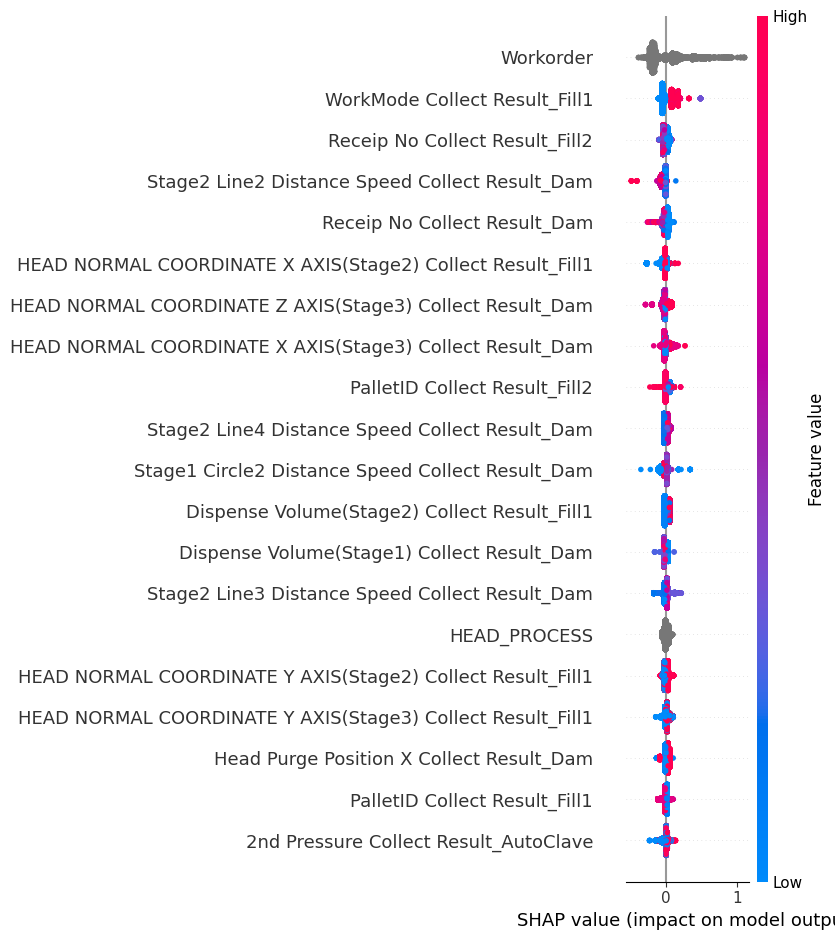

In [34]:
import shap

# SHAP 값 계산
explainer = shap.TreeExplainer(models[0])
shap_values = explainer.shap_values(X_test)

# SHAP 피처 중요도 시각화
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)